# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

<img src='assets/one_hot_encoding.png' width=50%>

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='assets/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=50%>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="assets/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

<img src="assets/vector_distance.png" width=40%>


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [2]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 17005207
Unique words: 253854


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [4]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(len(train_words))

4979509


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)


In [7]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [1, 2, 3, 4, 6, 7, 8, 9]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 3, 3]
y
 [1, 0, 2, 3, 1, 3, 1, 2]


## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [11]:
import torch
from torch import nn
import torch.optim as optim

In [12]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss .

In [13]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 128):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

on | deoxycortisol, edukacine, pembury, qawl, matriarchy
into | arpichordum, ktzn, spermophilus, kafti, tanguy
six | rodnay, subdivided, baenan, parable, hamakaviyim
been | libice, spriggan, mimeographs, kreidekreis, sakyamuni
seven | finlay, arkalochori, gebhardt, kosti, etexts
there | fringe, sbcs, amazulu, kmf, mlvl
no | emphases, orienting, ungrounded, estenssoro, guitarist
history | architectus, jersies, matapan, saumaise, sunium
numerous | dile, iisi, sidequel, coninx, infiltrated
mathematics | electricitatis, speccies, squee, perimeter, analysts
quite | overactivity, erchyll, coset, mbunga, initiates
derived | reformism, presleys, istaevones, whiting, harkinson
magazine | hexavalent, neroghoutioun, harington, shoveller, tonty
ocean | nagami, oneiroi, ewos, maneki, demonstrata
square | premchandra, accusatory, localisation, hammarberg, lessard
test | walach, pantechnicon, recitals, logue, mrt
...
into | ktzn, arpichordum, spermophilus, jamaa, kafti
used | cervix, homoeroticism, t

been | libice, caldecott, brummond, kreidekreis, mimeographs
many | puppa, mellers, heeding, slowing, anthon
see | panchos, triglyphs, secluding, calaenae, lehras
six | rodnay, lugbara, hamakaviyim, mcadams, baenan
had | mineralogist, wagered, tovah, comsat, vologda
four | assemblyman, servicedesk, jakina, gymnogyps, oxie
that | thrum, vomiting, glocks, fatana, conchoidal
one | straddled, shawm, tentsik, commentarii, zero
stage | sealance, groupoid, classicdoom, embittered, fremona
writers | englobing, sayhey, aeq, stalemate, gorgosaurus
placed | speculations, doohan, combattant, mariale, lba
question | dimple, kazel, unassailable, plash, baling
dr | triumviri, yehowzabad, hontoria, dalriadan, interpolitical
behind | slaughterhouse, emancipating, resize, ornstein, mepis
san | gbr, hkl, baillement, riba, kemmerg
applied | expediting, aleck, ebayer, therlands, objectify
...
such | mokuroku, keifer, undesignated, agilolfing, kml
during | medhat, enthlapy, curry, crevices, ferreorostris
mo

which | speciesism, breastbone, varphi, sifvast, throated
he | disdrometer, aerobatic, typol, kaballists, meanest
if | sculpted, cadie, reddish, decorous, stockingers
called | anvil, bavarica, schumacher, countermand, ours
nine | five, one, zero, two, seven
it | santhals, biotene, of, juigalpa, creditors
there | amazulu, sbcs, frith, pansaers, bilharz
th | arteriorgram, hardback, imperfections, irishmen, fand
applied | expediting, aleck, immatura, ebayer, therlands
pressure | hammilchamot, controversially, comique, sudoplatov, gentili
running | willpower, nicknames, outrigger, kilojoules, paradisiacal
powers | jamnitzer, freakonomics, vivisections, osterloh, orcuttiana
defense | warlording, angerburg, greer, recor, jaguarete
alternative | hundertwasserhaus, flixborough, combination, youcai, overseen
know | barcoded, distressed, clapp, dungbeetle, draig
quite | liberalis, overactivity, rtvslo, owes, varies
...
if | cadie, decorous, stockingers, sculpted, majed
new | meseguer, victrola, 

are | above, blaikie, archaebacteria, sakhalin, limborch
up | antza, gamprin, samper, sourcebook, anderson
when | betz, misused, rhosneigr, naiadi, documentable
war | hem, succeeded, zaragoza, sakia, ottoman
have | milieu, ballala, like, ashok, pomosexual
only | scholastically, represents, fix, tauroctony, quordlepleen
two | five, one, nine, six, four
four | one, zero, two, eight, seven
additional | applet, breazeale, valuance, progressions, minibuses
event | expose, remerciez, slien, rabine, stranglers
resources | molecular, staling, haigner, zwinger, ulaid
hit | haj, persianus, jt, shooter, shoreless
pressure | tissues, usefulness, buggles, pleasers, arvo
behind | lepadidae, resize, sedykh, globalsecurity, rnb
recorded | dispatched, fountaine, heteronormative, raddei, lyrics
police | nostrae, flashcarts, enlistment, punditry, indecision
...
his | he, him, she, wife, misanthropic
years | zero, five, globalnet, deaths, bristletails
seven | nine, one, five, three, eight
has | quatloos, 

not | i, that, what, arrestee, tattoos
during | shaiva, picqa, chimaki, prophesying, angrily
often | vallamkali, different, tici, abuha, tagari
he | his, him, her, who, brother
into | ptca, welter, ceramics, hockery, odo
but | to, how, primenet, smoczej, bogaert
new | university, york, three, eoksa, meseguer
called | countermand, hypercapnia, sievert, excelsior, together
report | dvoe, congressional, derivatives, clinton, shantarakshita
assembly | constitutional, constitution, elections, party, elect
pressure | buggles, comique, usefulness, salicifolia, gentili
brother | father, son, he, emperor, reign
egypt | forelock, turnagra, zenawi, rapida, tarnow
creation | silkworth, baulks, requite, amande, prikaatinkenraali
operating | system, designed, iovine, shotokai, os
san | hkl, california, los, biakabutuka, juan
...
which | by, tomtebobarnen, the, a, perdicaris
will | can, domain, dynamic, lower, hand
where | sum, projection, mannar, trigonometric, protector
of | s, the, in, by, on
worl

between | since, formed, in, made, fistula
can | are, used, is, trilateration, amount
who | her, want, s, servant, bob
state | united, government, ruling, democratic, civil
with | lofs, and, iob, kurumbas, acidobacteria
of | the, in, on, by, was
not | all, that, do, gorica, so
when | he, then, kizil, to, up
resources | portal, mining, whs, staling, burggraf
institute | university, external, medicine, harold, research
powers | legislative, prime, dupage, constitution, vested
heavy | oopsla, postmodernism, vorbis, classical, sestak
frac | p, x, infty, equation, pi
discovered | discovery, sleptons, selkirkshire, strissel, linales
proposed | privy, nesfa, speeches, ngall, runningback
recorded | pyrotechnician, raddei, fountaine, parve, mopti
...
than | arcere, galatai, intonation, psdb, siemowit
between | most, formed, fistula, lahore, hassemer
will | would, hand, that, then, you
be | are, or, used, if, is
no | el, import, moss, back, ludovisi
however | arrive, even, spah, avil, hypoxanthi

only | at, for, they, it, still
states | united, state, republic, act, political
it | a, the, or, is, other
seven | one, six, five, eight, four
also | is, a, of, and, the
where | at, located, ebirah, crystalinks, from
an | by, in, a, nine, s
war | army, ii, conflict, troops, civil
ocean | atlantic, pacific, coast, islands, stations
magazine | news, online, research, dvrs, gershwins
additional | used, using, superset, beltraneja, silent
defense | u, agency, military, agencies, denied
something | know, i, you, alured, your
shows | known, tv, television, several, with
creation | guid, assembly, biarritz, asperrima, follow
stage | guest, stages, kyp, big, hermai
...
that | to, is, the, a, not
b | d, one, eight, nine, n
it | a, the, is, to, example
first | line, bramante, moved, time, the
these | are, structures, can, use, many
or | can, usually, to, are, a
used | use, commonly, is, as, display
when | just, with, what, a, out
recorded | albums, alibis, pyrotechnician, knucklehead, charts
en

one | four, three, eight, two, seven
are | these, form, of, some, different
after | the, was, ended, then, soon
used | languages, commonly, alphabet, use, common
th | rd, calendar, century, nd, days
seven | one, three, nine, eight, four
can | is, or, these, are, such
during | allies, by, after, months, began
pre | language, details, the, see, architectural
channel | stations, network, cable, channels, tv
placed | placing, rinda, plastic, monument, full
dr | s, nine, four, d, one
units | unit, measurement, si, innerhalb, dnevni
defense | israeli, personnel, forces, infantry, bank
freedom | rights, publication, political, framework, parties
smith | sir, american, writer, actor, author
...
that | is, not, then, describe, good
b | d, seven, nine, one, writer
with | in, and, two, has, known
eight | six, one, seven, two, five
in | also, and, known, with, is
which | is, the, not, but, by
on | and, in, its, now, also
six | zero, eight, five, one, three
hold | them, agiocochook, usamo, god, him

war | forces, troops, civil, army, invasion
more | associated, groups, around, wikiwoordenboek, involves
time | elongates, npf, conopodium, suthanthirap, deliberately
from | in, of, by, and, is
or | is, with, can, are, an
in | of, and, the, from, for
this | an, basic, be, a, could
six | five, three, eight, one, zero
numerous | valvuloplasty, been, untouched, religious, culture
behind | nose, ball, yards, chrysogaster, fed
construction | building, buildings, industrial, built, factory
universe | fantastic, aristophanes, opposite, beings, marvel
award | awards, nominated, best, academy, prize
creation | adam, altizer, mockeries, ofiar, translating
older | family, age, families, household, females
gold | silver, iron, clay, bronze, steel
...
its | and, in, the, industry, zero
such | used, containing, known, fruit, use
however | rickenbocker, widespread, unarguable, scol, tranchet
use | used, commonly, especially, common, types
world | in, zero, nine, official, europe
are | of, is, other, 

states | united, america, kingdom, constitution, rights
first | by, became, later, th, beginning
american | singer, actors, actress, african, musician
he | his, him, her, brother, mother
this | follows, is, if, that, any
no | gegenwartskunst, walad, hypothesizing, might, ananias
with | general, is, a, of, and
five | zero, four, seven, three, eight
recorded | album, songs, toured, albums, blues
resources | mining, site, spore, agriculture, land
creation | judaism, ldsvoices, kaboom, evolution, biblical
running | run, ran, runs, operating, platform
accepted | scholars, legal, law, efficacy, outshone
http | www, com, edu, org, htm
bbc | news, cnn, radio, march, tv
lived | fossils, avitus, died, name, marry
...
was | after, later, remained, had, who
seven | eight, six, five, one, two
four | five, six, one, eight, two
system | consists, management, systems, the, cryptosporidium
d | l, o, g, n, e
than | represent, least, somewhat, larger, ziyarid
but | him, parr, not, pseudophyllinae, might


many | other, archaeological, modern, based, been
was | nine, his, later, named, s
often | disagree, manner, sometimes, broadly, similar
there | is, are, disarticulation, over, of
american | actress, births, actor, born, singer
their | other, khra, or, are, laevis
in | the, of, s, and, three
b | d, mathematician, k, c, laureate
cost | costs, consumer, expensive, delays, reduce
egypt | arab, egyptian, jordan, ghana, libya
account | nimis, volume, books, eight, theologian
freedom | freedoms, rights, liberty, duty, distinguished
award | awards, academy, won, winners, nominated
mathematics | mathematical, harvard, elementary, geometry, computation
experience | psychological, patients, cente, motivation, addicted
versions | version, compatible, releases, windows, video
...
first | nine, bell, by, a, scientist
it | see, correct, java, is, untilled
or | be, is, plural, which, of
a | s, is, called, e, v
will | keep, ensure, helps, tips, tend
history | references, external, timeline, historical

about | www, come, have, us, to
d | b, one, eight, l, r
but | non, the, existed, appear, realm
years | male, birth, expectancy, female, population
no | import, rs, without, commands, rasmus
use | or, software, specific, component, intermediate
can | or, amounts, chemical, is, methods
if | any, x, we, n, must
report | w, department, agency, agencies, news
bbc | listing, february, broadcast, radio, broadcasting
ocean | atlantic, pacific, islands, earth, north
consists | each, branch, or, legislative, comprising
woman | female, children, male, girl, fertility
engineering | research, technology, science, engineers, techniques
file | files, formats, user, client, software
except | usually, geographical, diacritics, upper, extends
...
had | he, his, died, him, afterwards
these | of, often, contain, into, are
be | is, or, not, mean, which
in | eight, and, the, one, of
five | eight, three, zero, seven, four
and | in, eight, of, five, wife
many | especially, such, lexicon, literature, considera

two | zero, one, five, four, six
or | are, like, not, used, rejection
has | by, its, as, and, both
american | writers, deaths, americans, university, natives
these | areas, communities, their, some, numerous
between | both, differences, part, because, but
history | references, modern, links, timeline, list
when | august, wouldn, would, after, the
discovered | found, discovery, mathematician, constructed, telescope
units | unit, customary, si, metre, regiment
primarily | most, including, commonly, syntax, compared
instance | strictly, usually, signifies, atas, kvin
taking | break, au, suffering, earned, toupper
except | slavic, separates, region, northwest, lands
engineering | laboratory, undergraduate, engineers, electronics, industrial
notes | note, bibliography, html, bass, concert
...
war | troops, forces, defeat, invasion, allies
after | returned, nine, soon, out, one
five | zero, three, six, one, seven
there | small, four, years, place, those
of | a, the, and, seven, in
it | a, i,

when | hit, t, trapped, get, would
there | are, means, many, prefer, to
been | small, many, affected, treated, by
eight | six, nine, three, five, four
this | which, defined, the, were, is
into | the, forming, along, small, group
from | old, with, order, l, of
up | side, few, just, finally, their
assembly | seats, elections, legislative, deputies, vote
joseph | john, born, benjamin, j, henry
award | awards, hugo, best, academy, honorary
account | libri, accounts, isaac, gaffurius, hominini
quite | more, shairing, well, inhospitable, melodic
brother | son, eldest, father, nephew, him
mathematics | mathematical, studied, fundamental, geometry, physics
instance | suffix, e, derivation, whereas, equation
...
its | the, of, and, on, from
world | nine, in, war, eight, europe
one | five, four, nine, three, six
their | who, that, have, with, local
will | you, may, does, would, if
used | using, uses, or, such, use
can | used, ability, required, if, or
than | more, is, population, less, have
univ

as | the, known, of, in, form
no | what, t, or, have, pi
system | systems, multiple, consists, programs, scale
it | because, is, as, considered, said
their | into, most, exclusively, to, they
on | and, two, the, nine, in
many | among, as, most, examples, some
at | near, of, two, by, from
dr | nine, b, eight, d, singer
orthodox | churches, church, christianity, catholic, saints
road | street, highway, bridge, manchester, pedestrian
issue | dismiss, realities, political, legimini, constitution
numerous | notable, ahmednagar, surviving, band, known
taking | osworth, injury, over, applicationafter, downstroke
institute | research, university, mit, associates, faculty
units | unit, metre, si, metric, measurement
...
up | out, weeks, away, down, waiting
may | april, date, and, those, eight
can | is, used, specific, or, form
its | from, the, a, east, called
first | after, second, eight, third, one
also | is, name, and, to, other
have | there, some, these, with, it
by | the, of, in, was, after

five | six, one, zero, four, two
he | his, felt, who, parents, talking
by | the, from, and, was, on
time | first, longest, achieved, youngest, record
which | by, literally, said, is, word
into | and, from, to, when, of
a | the, an, form, on, used
have | there, studies, researchers, are, some
shown | u, tourmaline, be, knifefish, forms
quite | though, me, iae, earlier, been
powers | executive, vested, exercised, legislative, ministers
brother | wife, son, cousin, eldest, grandfather
governor | appointed, lieutenant, deputy, executive, governors
hold | lactalis, bromate, stadiums, leave, masterman
universe | cosmology, cosmic, bang, earth, horizon
primarily | classifications, engineering, important, development, plants
...
i | t, my, says, myself, am
known | name, of, aka, found, popular
some | such, have, often, other, by
a | the, of, from, form, another
american | actor, musician, footballer, singer, singers
people | vegetarians, americans, diaspora, tribes, speak
up | fallen, they, mm

i | am, you, ve, replied, t
an | as, a, has, is, treated
he | his, was, himself, who, him
system | systems, computing, peripheral, operating, controls
use | used, or, easy, such, uses
where | house, given, left, northward, right
used | is, use, modern, as, word
also | names, various, from, as, website
issue | issues, dismiss, emergence, councilmember, legal
shows | bionic, television, abc, aired, lindun
experience | consciousness, physical, mental, memories, psychological
versions | compatible, xp, version, windows, microsoft
san | diego, francisco, jose, los, del
egypt | egyptian, alexandria, cairo, ancient, patriarch
articles | com, article, links, www, pdf
square | mile, area, street, miles, dome
...
war | army, soviet, military, forces, allies
been | discovered, as, were, these, prehistoric
between | central, and, divided, interior, neighbouring
during | throughout, war, unprecedented, period, years
into | inside, breaks, away, surrounding, near
to | on, would, started, do, and
wou

all | are, the, y, is, there
war | troops, soviet, uprising, hitler, allied
more | than, larger, even, though, be
are | is, types, identical, or, groups
on | five, onto, in, through, coats
an | a, of, is, with, prime
american | nine, musician, actor, one, actress
i | ve, t, know, myself, you
mainly | troublesome, groups, small, malay, fathead
defense | defence, of, ministry, christian, corps
centre | city, downtown, center, located, commerce
troops | surrendered, army, battle, invasion, occupied
nobel | prize, laureate, physicist, b, scientist
consists | branch, legislative, bodies, executive, bicameral
cost | costs, price, expensive, pcs, ibm
instance | more, that, are, of, r
...
all | given, let, another, are, the
where | v, n, left, delta, unique
into | with, whose, lands, contains, responsible
as | of, and, has, with, the
most | in, group, also, as, of
called | set, n, function, r, c
so | can, way, be, merely, good
only | minute, jaw, or, delivered, would
hit | singles, album, hits

seven | one, six, three, eight, nine
five | six, zero, three, four, one
after | one, march, lost, eight, zero
when | cousin, up, pregnant, seven, then
up | picked, side, shot, then, out
may | referred, take, each, it, other
nine | one, three, eight, four, zero
been | evidence, discovered, was, there, were
issue | issues, articles, contentious, opinion, regarding
hit | hitting, singles, run, gehrig, hits
additional | gentium, pili, specific, each, equivalents
frac | cos, infty, cdot, sqrt, x
defense | defence, department, personnel, u, civilian
woman | female, children, male, fertility, noun
instance | kind, specific, eucaryote, abstract, convenor
behind | shot, hands, front, missed, skansen
...
for | include, or, in, a, called
in | and, one, the, three, of
is | it, be, in, the, called
two | three, one, zero, six, eight
will | do, sure, that, all, to
has | in, such, most, of, likely
with | of, which, as, and, a
into | called, to, from, together, found
mainly | and, in, as, include, turk

will | may, you, do, the, said
often | sometimes, or, like, a, frequently
united | states, federation, u, also, south
some | are, modern, that, most, as
other | such, include, considered, by, to
a | the, in, with, like, is
to | the, in, are, of, a
world | in, see, of, five, an
pre | century, as, ancient, modern, in
defense | defence, israeli, department, security, commission
dr | s, nine, robert, eight, interview
something | know, what, you, t, i
proposed | proposal, status, referendum, proposals, the
operations | operation, air, map, military, fighters
behind | front, the, drop, die, cover
nobel | prize, laureate, physicist, physiology, chemist
...
use | such, used, often, type, an
zero | four, two, eight, three, six
was | in, one, nine, became, the
history | links, sources, list, ancient, origins
five | six, four, one, three, zero
or | such, similar, can, may, a
this | that, s, the, for, as
when | using, out, once, help, came
accepted | accurately, literature, definitions, practition

its | the, of, due, and, in
were | the, first, in, still, only
eight | seven, one, six, four, five
most | many, some, in, such, significant
first | the, in, were, also, was
three | one, five, two, four, six
their | survived, with, class, they, teachers
than | less, such, smaller, is, significantly
police | officer, executed, secret, arrested, battalion
marriage | heterosexual, homosexual, divorce, sexual, marriages
road | street, railway, highway, centre, built
scale | scales, industrial, indicate, below, octave
pressure | displacement, process, liquid, intake, solvent
versions | version, microsoft, operating, linux, software
instance | defined, syntax, is, be, a
running | operating, ran, unix, platform, windows
...
with | and, in, the, to, such
at | in, two, s, the, six
use | systems, available, using, uses, powerful
six | five, eight, four, two, one
only | at, first, made, to, based
can | is, or, are, example, such
a | and, in, to, the, then
war | battle, nazi, fought, forces, world


most | of, well, very, is, been
five | six, two, three, eight, one
where | coastal, a, being, ni, from
after | afterwards, temporarily, later, soon, eleven
i | my, you, t, am, b
were | their, thousand, became, and, having
a | the, of, and, in, by
world | war, olympic, germany, tournaments, ninuki
cost | costs, range, expensive, prices, demand
something | it, feel, if, you, happy
file | files, format, formats, xml, data
operating | os, platform, unix, mac, software
proposed | proposal, theories, evolution, proposals, gwaed
award | awards, best, prize, awarded, academy
woman | her, girl, she, husband, hera
discovered | discovery, specimen, long, named, remains
...
the | of, and, a, in, by
over | three, the, five, two, zero
that | or, continues, not, do, other
new | august, york, including, began, day
it | from, very, a, the, as
no | do, there, unless, titles, may
as | and, also, of, the, by
most | is, of, for, been, other
lived | whom, returned, visited, found, until
pre | as, arabic, im

some | such, or, be, as, phrase
were | been, taken, such, the, was
they | them, or, were, horses, romans
people | americans, deaths, births, whom, person
while | not, modern, inhibitors, has, being
on | the, in, and, as, with
more | common, very, as, either, commonly
use | common, used, uses, combination, usually
test | tests, testing, cricket, rockets, tested
know | you, say, we, what, understand
numerous | kidnapping, facto, arrested, fertilisers, reports
rise | began, high, continuously, known, well
governor | governors, lieutenant, appointed, william, president
proposed | debated, theories, greg, proposal, researcher
square | mile, street, metres, kilometers, avenue
quite | makes, tend, proven, unknown, seldom
...
such | or, as, are, and, of
can | or, are, be, is, cube
system | systems, lines, engineering, rapid, gsm
between | forming, the, with, black, groups
from | to, e, sometimes, also, order
a | the, to, or, with, are
to | the, a, they, or, with
more | or, are, common, as, ver

as | and, of, words, word, with
known | also, s, and, by, word
five | six, eight, nine, three, one
zero | three, two, eight, one, six
are | and, contain, or, certain, groups
system | the, systems, communications, cellular, mobile
history | new, article, external, encyclopedia, historical
the | in, of, and, s, by
pre | modern, existed, early, revival, shiva
taking | right, f, mu, point, sum
bill | actor, wrestler, tommy, dave, johnson
issue | issues, debate, due, breakdown, his
discovered | discovery, discoveries, asteroid, scientist, jakob
cost | costs, cheaper, price, consumer, expensive
hit | hits, album, singles, song, record
magazine | newspaper, books, interview, tom, editor
...
state | congress, university, independent, secretary, democratic
had | was, afterwards, late, until, moved
used | use, as, usually, plural, binary
such | some, as, include, other, and
four | one, eight, nine, six, two
they | are, do, even, equally, understand
other | of, and, many, are, form
between | forc

KeyboardInterrupt: 

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [16]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [17]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

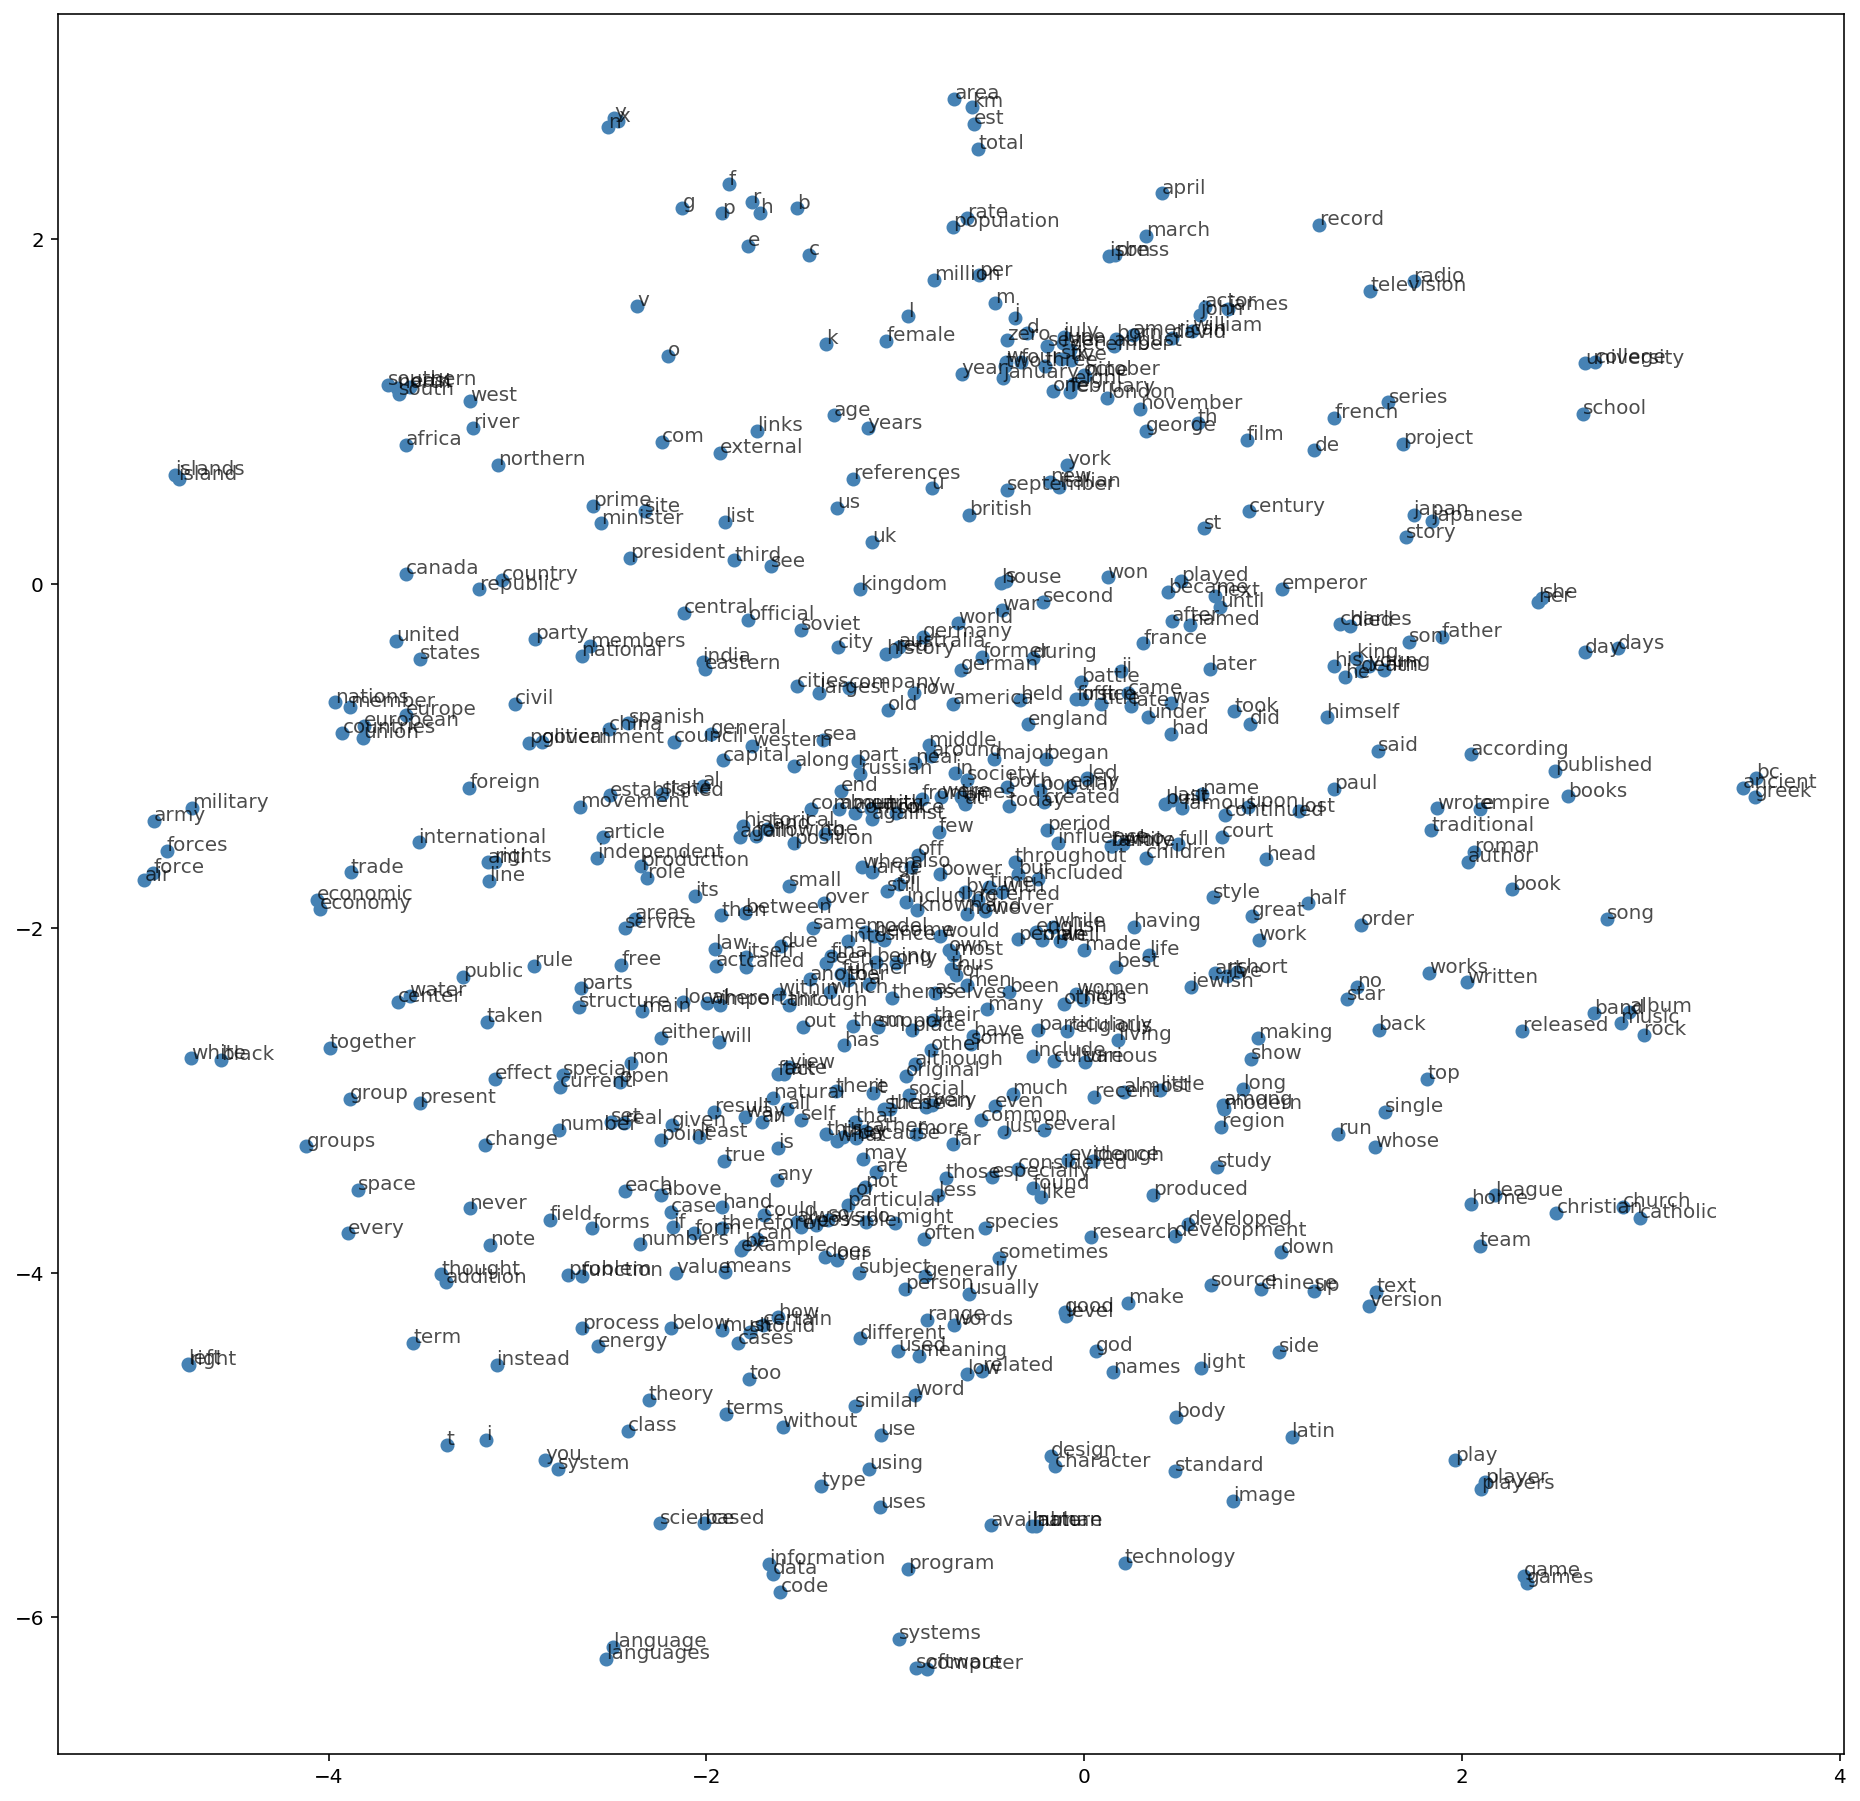

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [ ]:
# #play alert sound

# from IPython.display import Audio, display
# display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

# Store Training Weight And Params

In [19]:
model_name = 'SkipGram.net'

checkpoint = {'n_vocab': len(vocab_to_int),
              'n_embed': embedding_dim,
              'state_dict': model.state_dict()}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

# Load The Training Weight And Params

In [44]:
import torch
from torch import nn
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [45]:
with open('SkipGram.net', 'rb') as f:
    if torch.cuda.is_available():
        checkpoint = torch.load(f)
    else:
        checkpoint = torch.load(f, map_location='cpu')
    
loaded_model = SkipGram(checkpoint['n_vocab'], checkpoint['n_embed'])
loaded_model.load_state_dict(checkpoint['state_dict'])

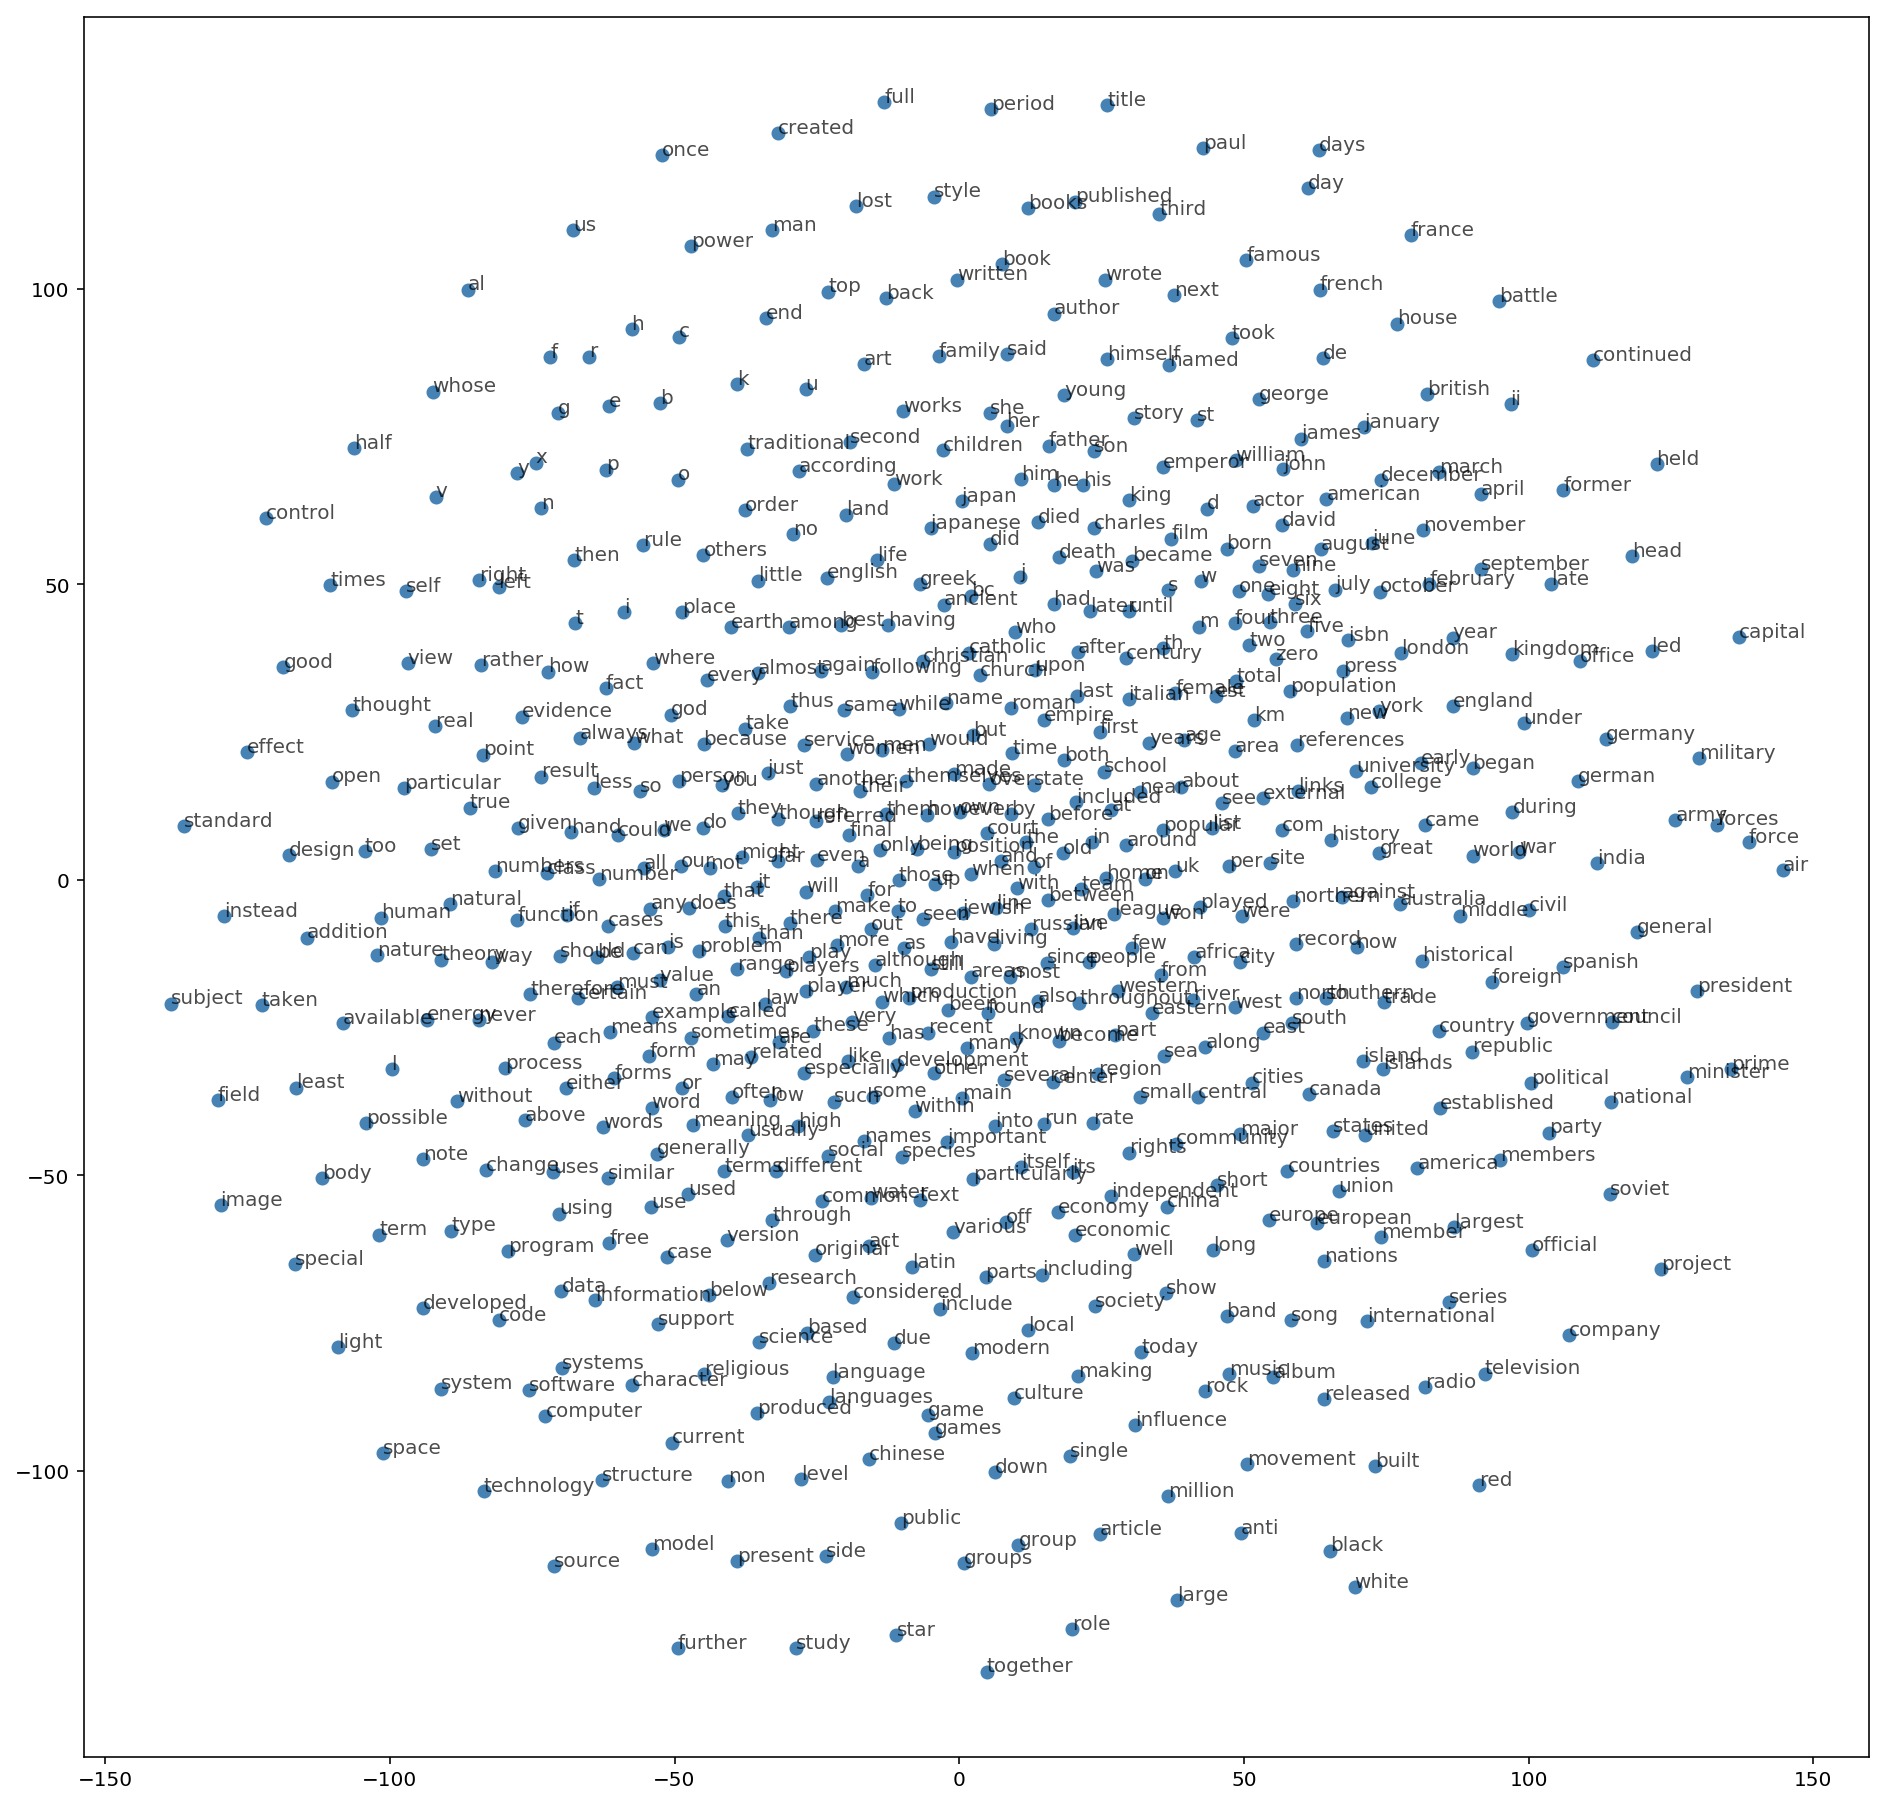

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# getting embeddings from the embedding layer of our model, by name
embeddings = loaded_model.embed.weight.to('cpu').data.numpy()

viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)